In [4]:
#%%
#            Chem 210A  begun 2017  Prof. McCurdy
#
"""  Template for calculating a potential curve 
        using psi4 as a python module
  
    Starting point for Chem 210A problems -- CWM November 1, 2017
    Modifications January 5 2020 and notes on guesses for UHF and HF
    calculations

    This starter script is set up to do Unrestricted Hartree Fock (UHF)
    calculation. That calculation breaks spin symmetry for internuclear
    distances greater than the Coulson-Fisher point, but gives the ordinary
    restricted Hartree-Fock solution for shorter internuclear distances

    Two changes do the Restricted Hartree Fock (RHF) calculation instead
   
    Minor changes allow MP2 and CISD calculations on this and other diatomics
    With suitable modifications this template can be used to calculate a bond 
    stretching curve for one bond in a polyatomic molecule.
      
"""
#%%
exit()

In [2]:
#                    IMPORT MODULES
#
import psi4  #  import all of psi4
import re as re   #  regular expression library -- used to modify the geometry object by replacing 
import matplotlib.pyplot as plt  
from datascience import *
%matplotlib inline
plt.style.use('fast')             #  a symbol with a number
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
psi4.set_memory('2048 MB') 

# minimum memory should be 1 GB. Generally  2GB or greater is better
filestring = 'output_diatomic.txt'   # file for complete output from Psi4 -- overwritten if it exists. 
psi4.core.set_output_file(filestring,False) 
filestring_plot = 'potcurve.dat'      # file for output of potential curve for plotting - see below.
                                     # overwritten if it exists.
print("psi4 output is directed to ",filestring,"\n")
#

psi4 output is directed to  output_diatomic.txt 



In [93]:
array1 = make_array(1,2,3,4)
array2 = make_array(6,9,20,8)
array3 = make_array(10,11,13,15)
array4 = make_array(1,3,5,7)

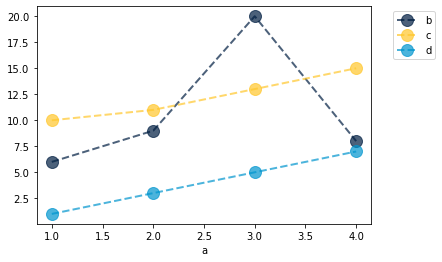

In [91]:
testing = Table().with_columns("a",array1,"b",array2,"c",array3,"d",array4)
testing.plot("a", marker='o' ,linestyle='dashed',
     linewidth=2, markersize=12)

1

In [3]:
#%%        RHF  6-311G
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE to use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF
# For linear molecules try c2v symmetry, which should be faster and
# will label orbital energies with symmetries in this point group
h2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 """

#   print the geometry 
print(h2_geometry)
#
#  parameters for the curve
#
N_Rvals = 50  # when debugging use a small number of R values
Rmin = 1.0    # use a larger Rmin for F2 in the Chem 210A assignment, Rmin = 1.5 is OK
Rmax = 8.0
dr = (Rmax-Rmin)/(N_Rvals-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': '6-311G'}) 
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({"reference": "rhf"})  # change "uhf" to "rhf" for restricted HF
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we run an initial point before the loop on R
#
#   guess_mix gives a guess that mixes alpha and beta spin orbitals to allow 
#   UHF to find the spin broken solution(s) for closed shells, like F2
#psi4.set_options({"guess_mix": 'true'})  # turn on only for UHF where it is essential
#                                          to break the spin symmetry and find the lower 
#                                          energy UHF solution instead of the HF solution
#
#   guess: core good for closed shell restricted Hartree-Fock 
#   should replace guess:  sad below for restricted Hartree-Fock 
#psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian  guess
#
#  some other guess options that help converge UHF calculations 
#psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
# New version of Psi4 in 2019 would not converge to UHF solution solution with SAD guess
# To get Psi4 to give the UHF solution for this example use  the Wolfsberg-Helmholgz Huckel first guess
psi4.set_options({'guess': 'gwh'})    # generalized Wolfsberg-Helmholz Huckel-like guess
#                                       works for ordinary restricted HF (RHF) as well
#psi4.set_options({"SOSCF": 'true'})   #  second order scf is quadratically convergent algorithm -- occasionally useful
psi4.set_options({"MAXITER": 500})    # If near 500 iterations are necessary, calculation is on the edge of failure
#
#  arrays for the R values and energies
#
Rvals=[]
Calculated_Energies=[]
#
#%%
# LOOP over R values 
#
for n in range(N_Rvals):
    R = Rmin + n*dr
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we put an if statement here to use this option
#                                     #  for n > 0, after first starting orbitals are defined
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object h2_geometry
# to make a new object h2_geo_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    h2_geo_R = re.sub("R_value",str(R),h2_geometry)
#
#    print(h2_geo_R)  # print current geometry -- uncomment for debugging
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf rohf uhf for example
#  'mp2'  also requires a reference (like rhf) as does 'cisd'
#
    finalenergy=psi4.energy('scf',molecule=psi4.geometry(h2_geo_R) )
#    print("R = ",R,"   psi4.energy   ", finalenergy)
    Rvals.append(R)
    Calculated_Energies.append(finalenergy)
#
#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#
f = open(filestring_plot,'w')  # rename this file for the case at hand
for n in range(N_Rvals):
    print(Rvals[n],"   ",Calculated_Energies[n])
    print(Rvals[n],"   ",Calculated_Energies[n],file=f)
#


      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 
1.0     -1.0802533248484312
1.1428571428571428     -1.1126575048380054
1.2857142857142856     -1.1259423667198778
1.4285714285714286     -1.1276354494872156
1.5714285714285714     -1.1222093865730904
1.7142857142857142     -1.1124059412304437
1.8571428571428572     -1.0999513735145914
2.0     -1.0859592698806675
2.142857142857143     -1.0711645873892128
2.2857142857142856     -1.0560624103538756
2.4285714285714284     -1.0409909354307776
2.571428571428571     -1.0261815429981027
2.7142857142857144     -1.0117898185202079
2.8571428571428568     -0.9979158759011184
3.0     -0.9846187577838443
3.142857142857143     -0.9719274142522284
3.2857142857142856     -0.9598494212623575
3.4285714285714284     -0.948377909143309
3.571428571428571     -0.937496897280828
3.714285714285714     -0.9271851879206113
3.8571428571428568     -0.9174190217014122
4.0     -0.9081737512163846
4.142857142857142     -0.8994

In [1]:
#                   RHF  6-311G**
#
import psi4  #  import all of psi4
import re as re   #  regular expression library -- used to modify the geometry object by replacing 
import matplotlib.pyplot as plt  
from datascience import *
%matplotlib inline
plt.style.use('fast') 
import os #  a symbol with a number
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
psi4.set_memory('2048 MB')           # minimum memory should be 1 GB. Generally  2GB or greater is better
filestringRHFstar = 'output_diatomicRHFstar.txt'   # file for complete output from Psi4 -- overwritten if it exists. 
psi4.core.set_output_file(filestringRHFstar,False) 
filestring_plotRHFstar = 'potcurveRHFstar.dat'      # file for output of potential curve for plotting - see below.
                                     # overwritten if it exists.
print("psi4 output is directed to ",filestringRHFstar,"\n")


#


#%%
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE to use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF
# For linear molecules try c2v symmetry, which should be faster and
# will label orbital energies with symmetries in this point group
h2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 """

#   print the geometry 
print(h2_geometry)
#
#  parameters for the curve
#
N_RvalsRHFstar = 50  # when debugging use a small number of R values
RminRHFstar = 1.0    # use a larger Rmin for F2 in the Chem 210A assignment, Rmin = 1.5 is OK
RmaxRHFstar = 8.0
drRHFstar = (RmaxRHFstar-RminRHFstar)/(N_RvalsRHFstar-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': '6-311G**'}) 
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({"reference": "rhf"})  # change "uhf" to "rhf" for restricted HF
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we run an initial point before the loop on R
#
#   guess_mix gives a guess that mixes alpha and beta spin orbitals to allow 
#   UHF to find the spin broken solution(s) for closed shells, like F2
#psi4.set_options({"guess_mix": 'true'})  # turn on only for UHF where it is essential
#                                          to break the spin symmetry and find the lower 
#                                          energy UHF solution instead of the HF solution
#
#   guess: core good for closed shell restricted Hartree-Fock 
#   should replace guess:  sad below for restricted Hartree-Fock 
#psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian  guess
#
#  some other guess options that help converge UHF calculations 
#psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
# New version of Psi4 in 2019 would not converge to UHF solution solution with SAD guess
# To get Psi4 to give the UHF solution for this example use  the Wolfsberg-Helmholgz Huckel first guess
psi4.set_options({'guess': 'gwh'})    # generalized Wolfsberg-Helmholz Huckel-like guess
#                                       works for ordinary restricted HF (RHF) as well
#psi4.set_options({"SOSCF": 'true'})   #  second order scf is quadratically convergent algorithm -- occasionally useful
psi4.set_options({"MAXITER": 500})    # If near 500 iterations are necessary, calculation is on the edge of failure
#
#  arrays for the R values and energies
#
RvalsRHFstar=[]
Calculated_EnergiesRHFstar=[]
#
#%%
# LOOP over R values 
#
for n in range(N_RvalsRHFstar):
    RRHFstar = RminRHFstar + n*drRHFstar
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we put an if statement here to use this option
#                                     #  for n > 0, after first starting orbitals are defined
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object h2_geometry
# to make a new object h2_geo_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    h2_geo_R = re.sub("R_value",str(RRHFstar),h2_geometry)
#
#    print(h2_geo_R)  # print current geometry -- uncomment for debugging
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf rohf uhf for example
#  'mp2'  also requires a reference (like rhf) as does 'cisd'
#
    finalenergy=psi4.energy('scf',molecule=psi4.geometry(h2_geo_R) )
#    print("R = ",R,"   psi4.energy   ", finalenergy)
    RvalsRHFstar.append(RRHFstar)
    Calculated_EnergiesRHFstar.append(finalenergy)
#
#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#
f = open(filestring_plotRHFstar,'w')  # rename this file for the case at hand
for n in range(N_RvalsRHFstar):
    print(RvalsRHFstar[n],"   ",Calculated_EnergiesRHFstar[n])
    print(RvalsRHFstar[n],"   ",Calculated_EnergiesRHFstar[n],file=f)
#

psi4 output is directed to  output_diatomicRHFstar.txt 


      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 
1.0     -1.0826592100123273
1.1428571428571428     -1.1160135691859854
1.2857142857142856     -1.1300340589876654
1.4285714285714286     -1.132202324508817
1.5714285714285714     -1.1270090999005915
1.7142857142857142     -1.117248883627318
1.8571428571428572     -1.1047094788006175
2.0     -1.0905565217344648
2.142857142857143     -1.0755589840434987
2.2857142857142856     -1.0602281976393937
2.4285714285714284     -1.044906302467962
2.571428571428571     -1.029823198956721
2.7142857142857144     -1.0151334037128692
2.8571428571428568     -1.0009399782110504
3.0     -0.9873099728250905
3.142857142857143     -0.9742841940523799
3.2857142857142856     -0.9618833232484953
3.4285714285714284     -0.9501120432939456
3.571428571428571     -0.9389624097333503
3.714285714285714     -0.928417092520408
3.8571428571428568     -0.9184525216637882
4.0

In [ ]:
#                   UFH  6-311G
#
import psi4  #  import all of psi4
import re as re   #  regular expression library -- used to modify the geometry object by replacing 
import matplotlib.pyplot as plt  
from datascience import *
%matplotlib inline
plt.style.use('fast') 
import os #  a symbol with a number
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
psi4.set_memory('2048 MB')           # minimum memory should be 1 GB. Generally  2GB or greater is better
filestringUFH = 'output_diatomicUFH.txt'   # file for complete output from Psi4 -- overwritten if it exists. 
psi4.core.set_output_file(filestringUFH,False) 
filestring_plotUFH = 'potcurveUFH.dat'      # file for output of potential curve for plotting - see below.
                                     # overwritten if it exists.
print("psi4 output is directed to ",filestringUFH,"\n")


#


#%%
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE to use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF
# For linear molecules try c2v symmetry, which should be faster and
# will label orbital energies with symmetries in this point group
h2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 """

#   print the geometry 
print(h2_geometry)
#
#  parameters for the curve
#
N_RvalsUFH = 50  # when debugging use a small number of R values
RminUFH = 1.0    # use a larger Rmin for F2 in the Chem 210A assignment, Rmin = 1.5 is OK
RmaxUFH = 8.0
drUFH = (RmaxUFH-RminUFH)/(N_RvalsUFH-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': '6-311G'}) 
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({"reference": "uhf"})  # change "uhf" to "rhf" for restricted HF
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we run an initial point before the loop on R
#
#   guess_mix gives a guess that mixes alpha and beta spin orbitals to allow 
#   UHF to find the spin broken solution(s) for closed shells, like F2
psi4.set_options({"guess_mix": 'true'})  # turn on only for UHF where it is essential
#                                          to break the spin symmetry and find the lower 
#                                          energy UHF solution instead of the HF solution
#
#   guess: core good for closed shell restricted Hartree-Fock 
#   should replace guess:  sad below for restricted Hartree-Fock 
#psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian  guess
#
#  some other guess options that help converge UHF calculations 
#psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
# New version of Psi4 in 2019 would not converge to UHF solution solution with SAD guess
# To get Psi4 to give the UHF solution for this example use  the Wolfsberg-Helmholgz Huckel first guess
psi4.set_options({'guess': 'gwh'})    # generalized Wolfsberg-Helmholz Huckel-like guess
#                                       works for ordinary restricted HF (RHF) as well
#psi4.set_options({"SOSCF": 'true'})   #  second order scf is quadratically convergent algorithm -- occasionally useful
psi4.set_options({"MAXITER": 500})    # If near 500 iterations are necessary, calculation is on the edge of failure
#
#  arrays for the R values and energies
#
RvalsUFH=[]
Calculated_EnergiesUFH=[]
#
#%%
# LOOP over R values 
#
for n in range(N_RvalsUFH):
    RUFH = RminUFH + n*drUFH
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we put an if statement here to use this option
#                                     #  for n > 0, after first starting orbitals are defined
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object h2_geometry
# to make a new object h2_geo_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    h2_geo_R = re.sub("R_value",str(RUFH),h2_geometry)
#
#    print(h2_geo_R)  # print current geometry -- uncomment for debugging
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf rohf uhf for example
#  'mp2'  also requires a reference (like rhf) as does 'cisd'
#
    finalenergy=psi4.energy('scf',molecule=psi4.geometry(h2_geo_R) )
#    print("R = ",R,"   psi4.energy   ", finalenergy)
    RvalsUFH.append(RUFH)
    Calculated_EnergiesUFH.append(finalenergy)
#
#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#
f = open(filestring_plotUFH,'w')  # rename this file for the case at hand
for n in range(N_RvalsUFH):
    print(RvalsUFH[n],"   ",Calculated_EnergiesUFH[n])
    print(RvalsUFH[n],"   ",Calculated_EnergiesUFH[n],file=f)
#

psi4 output is directed to  output_diatomicUFH.txt 


      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 


In [ ]:
#                   UFH  6-311G**
#
import psi4  #  import all of psi4
import re as re   #  regular expression library -- used to modify the geometry object by replacing 
import matplotlib.pyplot as plt  
from datascience import *
%matplotlib inline
plt.style.use('fast') 
import os #  a symbol with a number
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
psi4.set_memory('2048 MB')           # minimum memory should be 1 GB. Generally  2GB or greater is better
filestringUFHstar = 'output_diatomicUFHstar.txt'   # file for complete output from Psi4 -- overwritten if it exists. 
psi4.core.set_output_file(filestringUFHstar,False) 
filestring_plotUFHstar = 'potcurveUFHstar.dat'      # file for output of potential curve for plotting - see below.
                                     # overwritten if it exists.
print("psi4 output is directed to ",filestringUFHstar,"\n")


#


#%%
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE to use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF
# For linear molecules try c2v symmetry, which should be faster and
# will label orbital energies with symmetries in this point group
h2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 """

#   print the geometry 
print(h2_geometry)
#
#  parameters for the curve
#
N_RvalsUFHstar = 50  # when debugging use a small number of R values
RminUFHstar = 1.0    # use a larger Rmin for F2 in the Chem 210A assignment, Rmin = 1.5 is OK
RmaxUFHstar = 8.0
drUFHstar = (RmaxUFHstar-RminUFHstar)/(N_RvalsUFHstar-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': '6-311G**'}) 
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({"reference": "uhf"})  # change "uhf" to "rhf" for restricted HF
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we run an initial point before the loop on R
#
#   guess_mix gives a guess that mixes alpha and beta spin orbitals to allow 
#   UHF to find the spin broken solution(s) for closed shells, like F2
psi4.set_options({"guess_mix": 'true'})  # turn on only for UHF where it is essential
#                                          to break the spin symmetry and find the lower 
#                                          energy UHF solution instead of the HF solution
#
#   guess: core good for closed shell restricted Hartree-Fock 
#   should replace guess:  sad below for restricted Hartree-Fock 
#psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian  guess
#
#  some other guess options that help converge UHF calculations 
#psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
# New version of Psi4 in 2019 would not converge to UHF solution solution with SAD guess
# To get Psi4 to give the UHF solution for this example use  the Wolfsberg-Helmholgz Huckel first guess
psi4.set_options({'guess': 'gwh'})    # generalized Wolfsberg-Helmholz Huckel-like guess
#                                       works for ordinary restricted HF (RHF) as well
#psi4.set_options({"SOSCF": 'true'})   #  second order scf is quadratically convergent algorithm -- occasionally useful
psi4.set_options({"MAXITER": 500})    # If near 500 iterations are necessary, calculation is on the edge of failure
#
#  arrays for the R values and energies
#
RvalsUFHstar=[]
Calculated_EnergiesUFHstar=[]
#
#%%
# LOOP over R values 
#
for n in range(N_RvalsUFHstar):
    RUFHstar = RminUFHstar + n*drUFHstar
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we put an if statement here to use this option
#                                     #  for n > 0, after first starting orbitals are defined
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object h2_geometry
# to make a new object h2_geo_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    h2_geo_R = re.sub("R_value",str(RUFHstar),h2_geometry)
#
#    print(h2_geo_R)  # print current geometry -- uncomment for debugging
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf rohf uhf for example
#  'mp2'  also requires a reference (like rhf) as does 'cisd'
#
    finalenergy=psi4.energy('scf',molecule=psi4.geometry(h2_geo_R) )
#    print("R = ",R,"   psi4.energy   ", finalenergy)
    RvalsUFHstar.append(RUFHstar)
    Calculated_EnergiesUFHstar.append(finalenergy)
#
#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#
f = open(filestring_plotUFHstar,'w')  # rename this file for the case at hand
for n in range(N_RvalsUFHstar):
    print(RvalsUFHstar[n],"   ",Calculated_EnergiesUFHstar[n])
    print(RvalsUFHstar[n],"   ",Calculated_EnergiesUFHstar[n],file=f)
#

In [ ]:
problem2 = Table().with_columns("R",Rvals,"RHF-6-311G",Calculated_Energies,
                               "RHF-6-311G**",Calculated_EnergiesRHFstar,"UHF6-311G",Calculated_EnergiesUFH,
                              "UHF6-311G**",Calculated_EnergiesUFHstar)
problem2.plot(0)

In [ ]:
justRHF = Table().with_columns("R",Rvals,"RHF-6-311G",Calculated_Energies,"RHF-6-311G**",Calculated_EnergiesRHFstar)
justRHF.plot(0)

In [ ]:
#                    finalenergy=psi4.energy('mp2',molecule=psi4.geometry(h2_geo_R) )
#
#
import psi4  #  import all of psi4
import re as re   #  regular expression library -- used to modify the geometry object by replacing 
import matplotlib.pyplot as plt  
from datascience import *
%matplotlib inline
plt.style.use('fast') 
import os #  a symbol with a number
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
psi4.set_memory('2048 MB')           # minimum memory should be 1 GB. Generally  2GB or greater is better
filestringmp2 = 'output_diatomicmp2.txt'   # file for complete output from Psi4 -- overwritten if it exists. 
psi4.core.set_output_file(filestringmp2,False) 
filestring_plotmp2 = 'potcurvemp2.dat'      # file for output of potential curve for plotting - see below.
                                     # overwritten if it exists.
print("psi4 output is directed to ",filestringmp2,"\n")


#


#%%
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE to use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF
# For linear molecules try c2v symmetry, which should be faster and
# will label orbital energies with symmetries in this point group
h2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 """

#   print the geometry 
print(h2_geometry)
#
#  parameters for the curve
#
N_Rvalsmp2 = 50  # when debugging use a small number of R values
Rminmp2 = 1.0    # use a larger Rmin for F2 in the Chem 210A assignment, Rmin = 1.5 is OK
Rmaxmp2 = 8.0
drmp2 = (Rmaxmp2-Rminmp2)/(N_Rvalsmp2-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': '6-311G**'}) 
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({"reference": "rhf"})  # change "uhf" to "rhf" for restricted HF
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we run an initial point before the loop on R
#
#   guess_mix gives a guess that mixes alpha and beta spin orbitals to allow 
#   UHF to find the spin broken solution(s) for closed shells, like F2
#psi4.set_options({"guess_mix": 'true'})  # turn on only for UHF where it is essential
#                                          to break the spin symmetry and find the lower 
#                                          energy UHF solution instead of the HF solution
#
#   guess: core good for closed shell restricted Hartree-Fock 
#   should replace guess:  sad below for restricted Hartree-Fock 
#psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian  guess
#
#  some other guess options that help converge UHF calculations 
#psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
# New version of Psi4 in 2019 would not converge to UHF solution solution with SAD guess
# To get Psi4 to give the UHF solution for this example use  the Wolfsberg-Helmholgz Huckel first guess
psi4.set_options({'guess': 'gwh'})    # generalized Wolfsberg-Helmholz Huckel-like guess
#                                       works for ordinary restricted HF (RHF) as well
#psi4.set_options({"SOSCF": 'true'})   #  second order scf is quadratically convergent algorithm -- occasionally useful
psi4.set_options({"MAXITER": 500})    # If near 500 iterations are necessary, calculation is on the edge of failure
#
#  arrays for the R values and energies
#
Rvalsmp2=[]
Calculated_Energiesmp2=[]
#
#%%
# LOOP over R values 
#
for n in range(N_Rvalsmp2):
    Rmp2 = Rminmp2 + n*drmp2
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we put an if statement here to use this option
#                                     #  for n > 0, after first starting orbitals are defined
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object h2_geometry
# to make a new object h2_geo_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    h2_geo_R = re.sub("R_value",str(Rmp2),h2_geometry)
#
#    print(h2_geo_R)  # print current geometry -- uncomment for debugging
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf rohf uhf for example
#  'mp2'  also requires a reference (like rhf) as does 'cisd'
#
    finalenergy=psi4.energy('mp2',molecule=psi4.geometry(h2_geo_R) )
#    print("R = ",R,"   psi4.energy   ", finalenergy)
    Rvalsmp2.append(Rmp2)
    Calculated_Energiesmp2.append(finalenergy)
#
#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#
f = open(filestring_plotmp2,'w')  # rename this file for the case at hand
for n in range(N_Rvalsmp2):
    print(Rvalsmp2[n],"   ",Calculated_Energiesmp2[n])
    print(Rvalsmp2[n],"   ",Calculated_Energiesmp2[n],file=f)
#

In [ ]:
# to graph the 4 plots in part1
testing = Table().with_columns("R",Rvals,"RHF",CE1,"RHFgs1335",CE2,"UHF",CE3)
testing.plot(0)

In [ ]:
###CISD*******
#%% This is the H2_cisd file 
#   The output is the Calculated_Energies1






#            Chem 210A (and Chem 2A figures) 2021  Prof. McCurdy
#
"""  Template for calculating a potential curve 
        using psi4 as a python module
  
    This began from a starting point for Chem 210A problems -- CWM November 1, 2017

    CISD on H2.  Getting N_roots eigenvalues from the CI is implemented here for an,
                 in principle, arbitrary number of roots

      
"""

#%%
#                    IMPORT MODULES
#
import psi4  #  import all of psi4
import re as re   #  regular expression library 
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
# will work with small memory (512 MB, fopr example) for small cases but for CI larger memory
# is necessary for others
import matplotlib.pyplot as plt
psi4.set_memory('5120  MB')           # minimum memory should be 1 GB, 2GB or greater is better
#
filestring = 'output_H2_singlets_CISD.txt'          # file for complete output -- change name to save it 
psi4.core.set_output_file(filestring,False) # from being written over when doing another case
print("psi4 output is directed to ",filestring,"\n")
#

#%%
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE if we want to  use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
# For CISD c1 symmetry allow us to get singlet Sigma_g, Sigma_u, Pi_g, Pi_u
# etc. from a single CI calculation
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF

H2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry c1 """

#   print the geometry 
print(H2_geometry)

#
#  parameters for the curve
#
N_RvalsCISD = 50  # when debugging use a small number of R values
RminCISD = 1.0   # Minimum for H2 is near 1.4 bohr
RmaxCISD = 8.0
drCISD = (RmaxCISD-RminCISD)/(N_RvalsCISD-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': '6-311G**'}) # augmented basis to describe lowest Rydberg states
#psi4.set_options({'basis': 'cc-pvTZ'}) 
#
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({'reference': 'rohf'}) #DETCI seems to need rohf even if reference is equivalent to rhf 
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
psi4.set_options({'guess':'core'}) # diagonalize core hamiltonian (nuclear attraction only)
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#  if we run an initial point before the loop on R or after the first point
#

#
RvalsCISD=[]
Calculated_EnergiesCISD=[]
#
#%%
# LOOP over R values 
#
for n in range(N_RvalsCISD):
    R = RminCISD + n*drCISD
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object H2_geometry
# to make a new object H2_geometry_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    H2_geometry_R = re.sub("R_value",str(R),H2_geometry)
#
#    print(H2_geometry_R)  # print current geometry -- uncomment for debugging
#
    if (n != 0):
      psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
      #  if we run an initial point before the loop on R or after the first point
#
# set reference for CI
#    psi4.set_options({'SOCC':[2]}) # scf reference for triplet H2, for example 
#    psi4.set_options({'DOCC':[0]}) # 
    psi4.set_options({'SOCC':[0]}) #scf reference for singlet H2, for example 
    psi4.set_options({'DOCC':[1]}) #
#    freeze_array=[0]  # for freezing core orbitals in CISD in larger cases
#    psi4.set_options({'FROZEN_DOCC': freeze_array})
#
#  set number of CI roots here
    N_roots =  1 
#  For H2 singlets, the first three are the X Sigma_g^+, B Sigma_u^+ and E,F Sigma_g^+ 
    psi4.set_options({'NUM_ROOTS': N_roots})     
    psi4.set_options({'CI_MAXITER': 100})     
    psi4.set_options({'DIAG_METHOD':'DAVIDSON'}) # a little faster sometimes than default SEM
#
    finalenergy=psi4.energy('cisd',molecule=psi4.geometry(H2_geometry_R) )

#    finalenergy, wfcninitial  =psi4.energy('scf',molecule=NH3,return_wfn=True)
    print("R  = ",R,"   psi4.energy (CISD) singlet A  ", finalenergy)
    scf_energy = psi4.core.get_variable('SCF TOTAL ENERGY')
    print("scf energy = ",scf_energy)
    print("R = ",R,"   psi4.energy   ", finalenergy)
#

# This is how to get different CI root energies into python
# coded here with string construction to allow calculating N_roots eigenvalues
# 
    energyrootsCISD = []
    for iroot in range(N_roots):
       energyrootTemp  = psi4.core.get_variable('CI ROOT '+str(iroot)+' TOTAL ENERGY')
       energyrootsCISD.append(energyrootTemp)
    print("CI energies for roots  = ",energyrootsCISD)
#
    RvalsCISD.append(R)
    Calculated_EnergiesCISD.append(energyrootsCISD)
#

#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#

# reduced mass for ^4He_2
# = Mass of ^4He in u times mass of electron in u /2
mu  = (4.0015061791*1822.888486)/2.0
f = open('potcurve_H2_singlets.dat','w')  # rename this file for the case at hand
HatomEnergy = 0.0 # no shift of zero of energy to compare with other methods directly
#HatomEnergy = -0.5   # set a zero of energy for separated atoms for  potential curves
for n in range(N_RvalsCISD):
    for istate in range(N_roots):
       Calculated_EnergiesCISD[n][istate] = Calculated_EnergiesCISD[n][istate] - 2.0*HatomEnergy
    print(RvalsCISD[n],"   ",Calculated_EnergiesCISD[n][:] )
# change separator to make comma separated file (change extention to .csv) for plotting if necessary
    print(RvalsCISD[n],"   ",*Calculated_EnergiesCISD[n][0:N_roots],sep='   ',file=f)
#
#%%

In [ ]:
#"RHF-6-311G**",Calculated_EnergiesRHFstar
# 

# to graph the 3 plots in part3

plt.plot(RvalsCISD, Calculated_EnergiesCISD, color='r', label='CISD')
plt.plot(RvalsCISD, Calculated_EnergiesRHFstar, color='g', label='RHF-6-311G**')
# this will be the MP2 once I know how to run that
plt.plot(RvalsCISD, Calculated_Energiesmp2, color='b', label='MP2')
  
# Naming the x-axis, y-axis and the whole graph
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [ ]:
testing = Table().with_columns("R",Rvals,"RHF",CE1,"RHFgs1335",CE2,"UHF",CE3)
testing.plot(0)

In [ ]:
three_sigma_2pi= Table().with_columns("R",Rvals,"Energy",Calculated_Energies)
three_sigma_2pi.plot("R","Energy")

In [ ]:
# to graph the 2 plots used in question 3
testing = Table().with_columns("R",Rvals,"RHF",CE1,"RHFgs1335",CE2,"UHF",CE3)
testing.plot(0)

In [8]:
#%%
#
#  MAKE PLOTS FROM THE OUTPUT FILE OR PUT PLOTTING COMMANDS HERE
#  FOR A PROPERLY LABELED GRAPH 
#  plotting with xmgrace or other plotting code is recommended, and easier than plotting
#  several cases from this python script.  However, by doing several cases and saving the 
#  data in arrays, all plots can be made using python in a self contained script built on
#  this starter.
#
exit()